kaggle入门 Titanic: Machine Learning from Disaster

生存预测 `Binary classification`

In [1]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

# preview the data
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


```python
PassengerId => 乘客ID
Pclass => 乘客等级(1/2/3等舱位)
Name => 乘客姓名
Sex => 性别
Age => 年龄
SibSp => 堂兄弟/妹个数
Parch => 父母与小孩个数
Ticket => 船票信息
Fare => 票价
Cabin => 客舱
Embarked => 登船港口
```

In [3]:
titanic_df.info()
print ('=====' * 10)
test_df.info()
# test_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

查看对数据的理解，其中有一些缺失值，如`Age`、`Cabin`，权衡填充与舍弃

数据清洗

In [4]:
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

缺失值填充

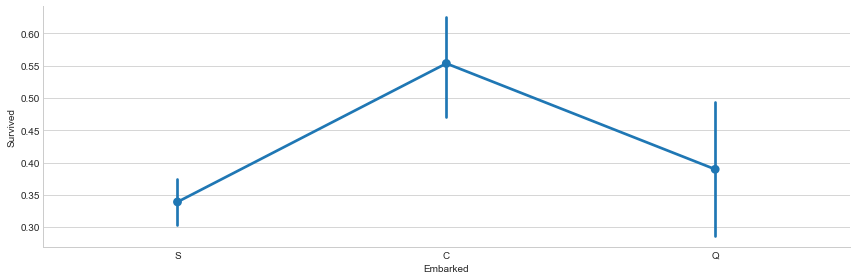

In [5]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

分类数据的绘制，X轴代表类别，Y轴为在该类别下的统计量，比如说均值，可以间接说明每个类别对`Surivived`的影响因子

特征工程

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 2 columns):
Embarked    3 non-null object
Survived    3 non-null float64
dtypes: float64(1), object(1)
memory usage: 152.0+ bytes


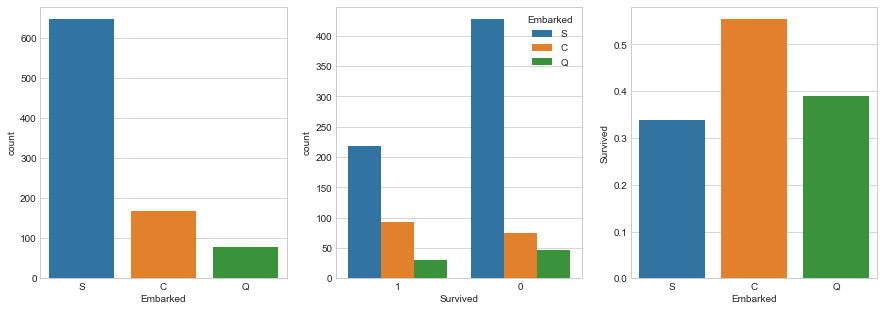

In [6]:
## Embarked
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)
embark_perc.info()

embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

0


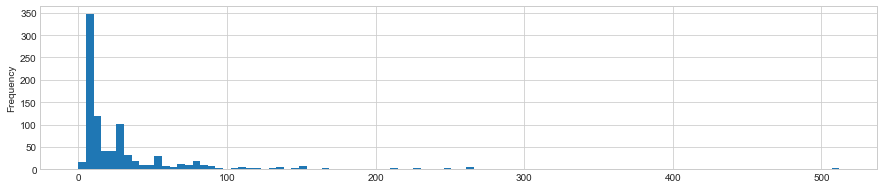

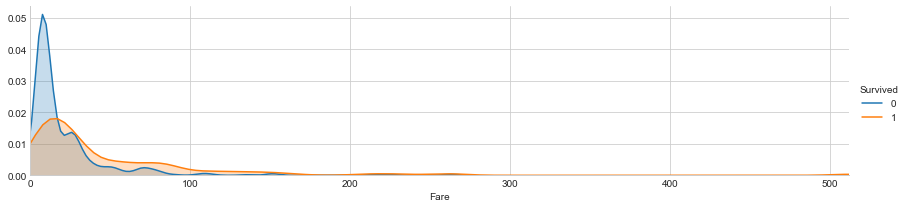

In [7]:
## Fare
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100)

facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
print (titanic_df['Fare'].min())
facet.set(xlim=(0, titanic_df['Fare'].max()))
facet.add_legend()

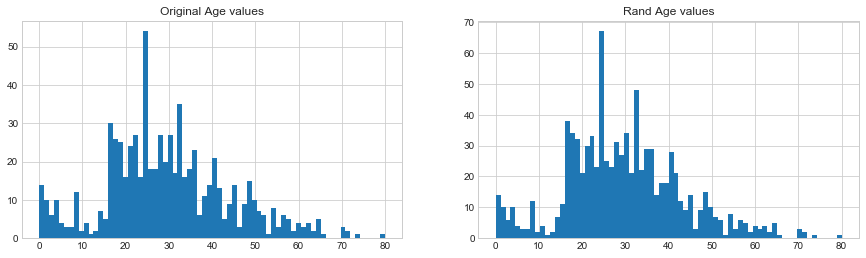

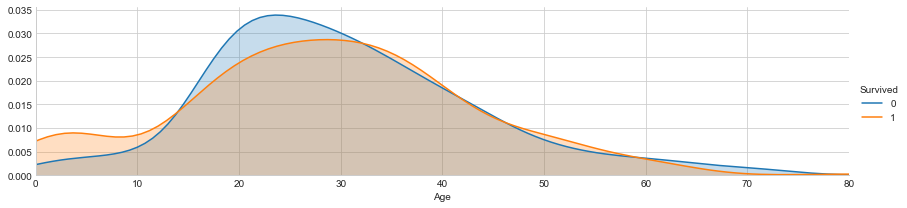

In [8]:
## Age
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
axis1.set_title('Original Age values')
axis2.set_title('Rand Age values')

average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()

average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
titanic_df.loc[np.isnan(titanic_df["Age"]), "Age"] = rand_1
test_df.loc[np.isnan(test_df["Age"]), "Age"] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

可以考虑将`Age`转换为类别变量

In [9]:
## Cabin
titanic_df.drop("Cabin", axis=1, inplace=True)
test_df.drop("Cabin", axis=1, inplace=True)

[Text(0,0,'With Family'), Text(0,0,'Alone')]

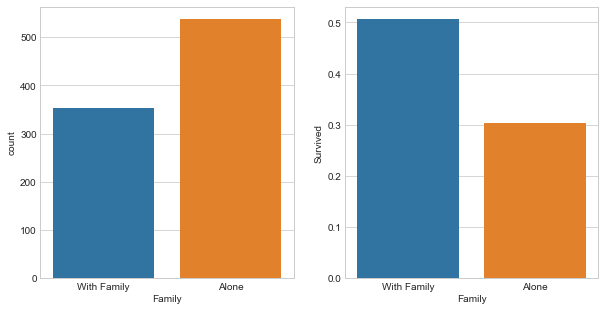

In [10]:
## Family
titanic_df['Family'] = titanic_df['Parch'] + titanic_df['SibSp']
titanic_df.loc[titanic_df['Family'] > 0, 'Family'] = 1
titanic_df.loc[titanic_df['Family'] == 0, 'Family'] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df.loc[test_df['Family'] > 0, 'Family'] = 1
test_df.loc[test_df['Family'] == 0, 'Family'] = 0

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=titanic_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

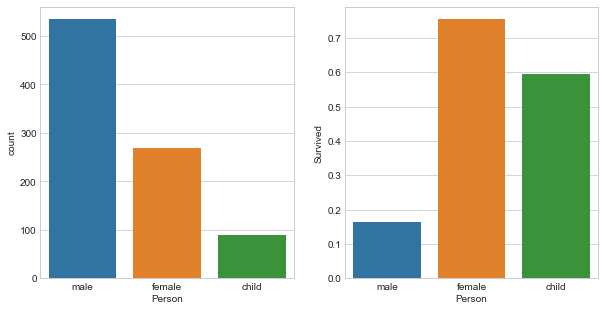

In [11]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

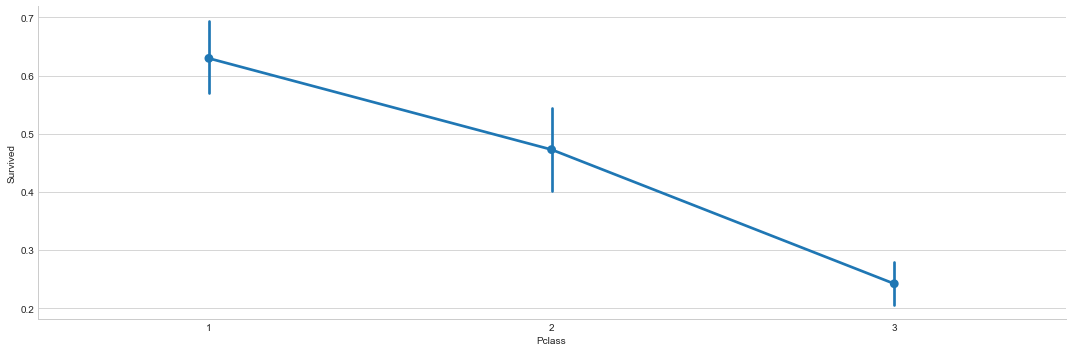

In [12]:
sns.factorplot('Pclass', 'Survived', order=[1,2,3], data=titanic_df, size=5, aspect=3)

pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

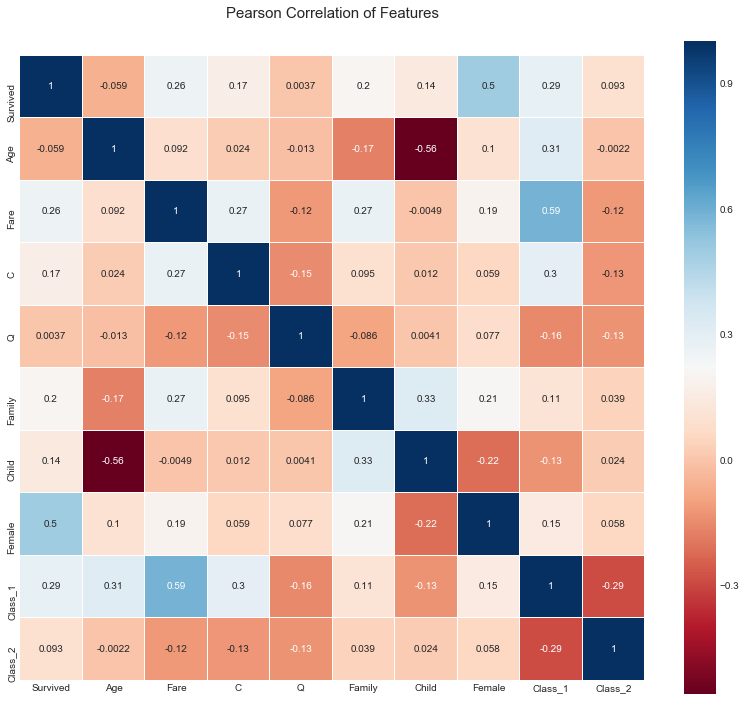

In [13]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(titanic_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

特征之间相关性分析

定义训练、测试数据集

In [14]:
X_train = titanic_df.drop('Survived', axis=1)
Y_train = titanic_df['Survived']
X_test  = test_df.drop("PassengerId",axis=1)

Logistic Regression

In [15]:
logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Age,-0.019755
1,Fare,0.001058
2,C,0.594193
3,Q,0.337609
4,Family,-0.251362
5,Child,1.957836
6,Female,2.739636
7,Class_1,1.963203
8,Class_2,1.100030


Support Vector Machine

In [16]:
# svc = SVC()

# svc.fit(X_train, Y_train)

# Y_pred = svc.predict(X_test)

# svc.score(X_train, Y_train)

Random Forests

In [17]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)
print (random_forest.fit(X_train, Y_train).feature_importances_)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

[ 0.32175039  0.23885961  0.02597588  0.01639329  0.02557856  0.03058687
  0.23928357  0.05390095  0.04767087]


0.96857463524130194

knn 

In [18]:
# knn = KNeighborsClassifier(n_neighbors = 3)

# knn.fit(X_train, Y_train)

# Y_pred = knn.predict(X_test)

# knn.score(X_train, Y_train)

Gaussian Naive Bayes

In [19]:
# gaussian = GaussianNB()

# gaussian.fit(X_train, Y_train)

# Y_pred = gaussian.predict(X_test)

# gaussian.score(X_train, Y_train)

In [20]:
submission = pd.DataFrame({
        "test_id": test_df["PassengerId"],
        "Survived": Y_pred
})
submission.to_csv('titanic.csv', index=False)